In [2]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
def adam_loves_theano(inp_list,cost,param_list,alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10e-8):
    # Create 2 theano functions that will be called sequentially
    # The first one "updates" the shared variables that go into the calculation of the parameter update
    # The second one combines them into an update
    
    # Create the first function:
    # Initialize the helper variables, one for each parameter (this will only happen once and doesn't affect updates)
    Ts = [theano.shared(0.)               for p in param_list] # t term in adam
    Ms = [theano.shared(p.get_value()*0.) for p in param_list] # m term in adam
    Vs = [theano.shared(p.get_value()*0.) for p in param_list] # v term in adam
    # Define each of their update rules
    up_t = [(T_,T_+1) for T_ in Ts]
    up_m = [(M,beta1*M + (1-beta1)*T.grad(cost,p))      for M, p in zip(Ms,param_list)]
    up_v = [(V,beta2*V + (1-beta2)*(T.grad(cost,p)**2)) for V, p in zip(Vs,param_list)]
    # Combine this into a full update list
    up_h = up_t + up_m + up_v
    # Create that first function
    f_adam_helpers = theano.function(inp_list,cost,updates=up_h)
    
    # Create the second function (during training, this is called right after calling the first):
    # Compute, using the updated helper variables, the components of the parameter update equation
    # (updated by the call to f_adam_helpers, which will occurr during training)
    mHat = [m / (1-(beta1**t)) for m, t in zip(Ms,Ts)]
    vHat = [v / (1-(beta2**t)) for v, t in zip(Vs,Ts)]
    # Use them to update the parameters
    up_p = [(p, p - (alpha*mH / (T.sqrt(vH)+epsilon))) for p, mH, vH in zip(param_list,mHat,vHat)]
    # Create your training function with this update
    f_train = theano.function(inp_list,cost,updates=up_p)
    
    return f_adam_helpers, f_train

In [4]:
def adadelta(inp_list,cost,param_list,rho=.95, epsilon=1e-6):
    """
    An adaptive learning rate optimizer

    Parameters
    ----------
    lr : Theano SharedVariable
        Initial learning rate
    tpramas: Theano SharedVariable
        Model parameters
    grads: Theano variable
        Gradients of cost w.r.t to parameres
    x: Theano variable
        Model inputs
    mask: Theano variable
        Sequence mask
    y: Theano variable
        Targets
    cost: Theano variable
        Objective fucntion to minimize

    Notes
    -----
    For more information, see [ADADELTA]_.

    .. [ADADELTA] Matthew D. Zeiler, *ADADELTA: An Adaptive Learning
       Rate Method*, arXiv:1212.5701.
    """

    ### = DESCRIPTION FROM LITERATURE
    
    # Initialize the helper variables, one for each parameter (this will only happen once and doesn't affect updates)
    # Standard gradients: g_t
    zipped_grads   = [theano.shared(p.get_value()*np.zeros(1).astype(theano.config.floatX))
                      for p in param_list]
    # Running expectation of squared update: E[ d[x]**2 ]_t
    running_up2    = [theano.shared(p.get_value()*np.zeros(1).astype(theano.config.floatX))
                      for p in param_list]
    # Running expectation of squared gradient: E[g**2]_t
    running_grads2 = [theano.shared(p.get_value()*np.zeros(1).astype(theano.config.floatX))
                      for p in param_list]
    

    
    ### Compute Gradient: g_t
    # Update rule for shared variables in zipped_grads (they just equal variables in grads)
    zgup = [(zg, T.grad(cost,p)) for zg, p in zip(zipped_grads, param_list)]
    
    ### Accumulate Gradient: E[g**2]_t = rho * E[g**2]_t-1  +  (1-rho) * (g_t)**2
    # Update rule for shared variables in running_grads2
    rg2up = [(rg2, 0.95 * rg2 + 0.05 * (T.grad(cost,p) ** 2))
             for rg2, p in zip(running_grads2, param_list)]

    # Function that, when called, applies the two above update rules
    # (during training, this is called, then f_update is)
    f_adadelta_helpers = theano.function(inp_list,cost,updates=zgup+rg2up)

    
    ### Compute Update: d[x]_t = - [ RMS(d[x])_t-1 / RMS(g)_t ] * g_t
    # Create symbolic variable out of zipped_grads, running_up2, and running_grads2 for each parameter
    updir = [-T.sqrt(ru2 + epsilon) / T.sqrt(rg2 + epsilon) * zg
             for zg, ru2, rg2 in zip(zipped_grads,
                                     running_up2,
                                     running_grads2)]
    
    ### Accumulate Update: E[ d[x]**2 ]_t = rho * E[ d[x]**2 ]_t-1  +  (1-rho) * (d[x]_t)**2
    # Update rule for ru2up (whatever that is)
    ru2up = [(ru2, 0.95 * ru2 + 0.05 * (ud ** 2))
             for ru2, ud in zip(running_up2, updir)]
    
    ### Apply Update: x_t+1 = x_t + d[x]_t
    # Final update rule for parameter, combining all that
    param_up = [(p, p + ud) for p, ud in zip(param_list, updir)]

    # Function to actually update the parameters (as well as ru2up)
    f_train = theano.function(inp_list,cost, updates=ru2up + param_up)

    return f_adadelta_helpers, f_train

In [5]:
# Pretty self explanatory
def init_iw(n_hidden,feats): return (np.random.normal(size=(n_hidden,feats))/10   ).astype(theano.config.floatX)
def init_hw(n_hidden,feats): return (np.random.normal(size=(n_hidden,n_hidden))/10).astype(theano.config.floatX)
def init_ow(n_hidden,feats): return (np.random.normal(size=(1,n_hidden))/10       ).astype(theano.config.floatX)

SGD vs Adam vs adadelta on a simple Multi-Layer Perceptron

In [5]:
# A simpler MLP (the RNN part is better commented)

# Input will be a sequence
# Processed through a hidden layer
# Output is a read on that network's final state
def fake_data(n_samps,true_iw,true_ow):
    n_hidden = true_iw.shape[0]
    inp_size = true_iw.shape[1]
    # the input is just random
    fake_inp = np.random.normal( size=(n_samps,inp_size) )
    h = np.tanh(np.dot(true_iw,fake_inp.T))
    # Return the input and output
    return fake_inp.T, np.tanh(np.dot(true_ow,h))
    
# Basic network parameters
feats = 10
n_hidden = 5

# Placeholders for input and target
INP = T.dmatrix('INP')
TARG = T.dmatrix('TARG')
# Initialization of parameters
iw = theano.shared(np.random.normal(size=(n_hidden,feats)).astype(theano.config.floatX),name='iw')
ow = theano.shared(np.random.normal(size=(1,n_hidden)).astype(theano.config.floatX),name='ow')

# Symbolic architecture of the model
h = T.tanh(T.dot(iw,INP))
out = T.tanh(T.dot(ow,h))
err = (out-TARG)**2
cost = err.sum()

# Gradient graphs => update rules for SGD and the final function for using it!
gi,go = T.grad(cost,[iw,ow])
w_updates_SGD = [(iw,iw-gi*.001),(ow,ow-go*.001)]
f_train_SGD = theano.function([INP,TARG],cost,updates=w_updates_SGD)

# A more general function that returns a pair of functions that, called sequentially, train using Adam!
f_adam_helpers, f_adam_train = adam_loves_theano([INP,TARG],cost,[iw,ow])
# This function implements that sequential calling into one trianing step:
def f_train_adam(INP,TARG):
    f_adam_helpers(INP,TARG)
    return f_adam_train(INP,TARG)

# Similar construction for ADADELTA
f_adadelta_helpers, f_adadelta_train = adadelta([INP,TARG],cost,[iw,ow])
def f_train_adadelta(INP,TARG):
    f_adadelta_helpers(INP,TARG)
    return f_adadelta_train(INP,TARG)

In [6]:
# Set aside some default weights for easy comparison of training methods
# "True" weights for fake data
dflt_iwT = init_iw(n_hidden,feats)
dflt_owT = init_ow(n_hidden,feats)
# Initial NN weights
dflt_iwN = init_iw(n_hidden,feats)
dflt_owN = init_ow(n_hidden,feats)

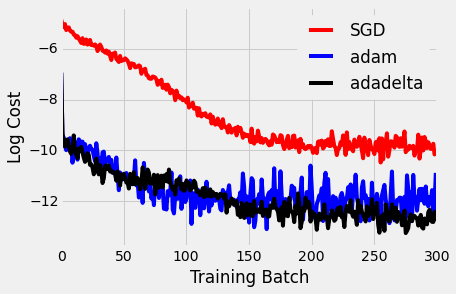

In [8]:
batchSize = 200 # "batch" is a misnomer -- really just number of costs to average 
nIters = 300 # Number of "batches"

# Reset parameters, train with SGD
iw.set_value(dflt_iwN)
ow.set_value(dflt_owN)
bCostSGD = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(1,dflt_iwT,dflt_owT)
        #
        currCost[i] = f_train_SGD(x,y)
    bCostSGD[b] = np.log(np.mean(currCost))

# Reset parameters, train with adam
iw.set_value(dflt_iwN)
ow.set_value(dflt_owN)
bCostAdam = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(1,dflt_iwT,dflt_owT)
        #
        currCost[i] = f_train_adam(x,y)
    bCostAdam[b] = np.log(np.mean(currCost))
    
# Reset parameters, train with adadelta
iw.set_value(dflt_iwN)
ow.set_value(dflt_owN)
bCostAdadelta = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(1,dflt_iwT,dflt_owT)
        #
        currCost[i] = f_train_adadelta(x,y)
    bCostAdadelta[b] = np.log(np.mean(currCost))

# Plot the progress of SGD and Adam (same "true" network, same starting params)
fig = plt.figure
ax = plt.axes();
ax.plot(np.arange(nIters),bCostSGD,'r-',np.arange(nIters),bCostAdam,'b',np.arange(nIters),bCostAdadelta,'k');
bCost = np.concatenate((bCostSGD,bCostAdam,bCostAdadelta))
ax.set_ylim([np.min(bCost)-.5,np.max(bCost)+.5]);
ax.set_ylabel('Log Cost');
ax.set_xlabel('Training Batch');
ax.legend(['SGD','adam','adadelta'],loc='best');

SGD vs Adam on an RNN!!!

In [7]:
# Input will be a sequence
# Processed through a recurrent network
# Output is a read on that network's final state
def fake_data(n_steps,true_iw,true_hw,true_ow):
    n_hidden = true_iw.shape[0]
    inp_size = true_iw.shape[1]
    # the input is just random
    fake_inp = np.random.normal( size=(inp_size,n_steps) )
    # Generate the hidden activation
    h = np.zeros((n_steps+1,n_hidden))
    for i in range(1,n_steps+1):
        h[i,:] = np.tanh(np.dot(true_iw,fake_inp[:,i-1]) + np.dot(true_hw,h[i-1,:].T))
    # Return the input and output
    return fake_inp.T, np.tanh(np.dot(true_ow,h[-1,:].T))


# In this cell we birth our variables and weave their fates in a symbolic graph.
# TDB. Top. To. Bottom... But backwards.

feats = 10
n_hidden = 5

# Inp is the input sequence
inp = T.dmatrix('inp')
# H is doubly named: hidden and hack. It's a placeholder, but necessary...
H = T.dvector('H')
# Y is the target
Y = T.dvector('Y')

# Our lovely parameters. They get passed around like condoms at an inner city Bar Mitzvah.
iw = theano.shared(init_iw(n_hidden,feats),name='iw')
hw = theano.shared(init_hw(n_hidden,feats),name='hw')
ow = theano.shared(init_ow(n_hidden,feats),name='ow')

# The recurrent graph. Takes the input sequence and returns hidden activation at each step.
res, updates = theano.scan(lambda X, h_prev: T.tanh(T.dot(iw,X) + T.dot(hw,h_prev)),
                          sequences=inp,
                          outputs_info=[T.alloc(np.zeros(1).astype(theano.config.floatX),n_hidden)] # This is the most reliable way to properly initialize the fcn output
                          )
# The final output graph. (Calculated using the final hidden state)
out = T.tanh(T.dot(ow,res[-1]))
# Graph steps for computing loss.
err = (out-Y)**2
cost = err.sum()

# Gradient graphs => update rules for SGD => the final function for using it!
gi,gh,go = T.grad(cost,[iw,hw,ow])
w_updates_SGD = [(iw,iw-gi*.001),(hw,hw-gh*.001),(ow,ow-go*.001)]
f_train_SGD = theano.function([inp,Y],cost,updates=w_updates_SGD)

# A more general function that returns a pair of functions that, called sequentially, train using Adam!
f_adam_helpers, f_adam_train = adam_loves_theano([inp,Y],cost,[iw,hw,ow])
# This function implements that sequential calling into one trianing step:
def f_train_adam(inp,Y):
    f_adam_helpers(inp,Y)
    return f_adam_train(inp,Y)

# Similar construction for ADADELTA
f_adadelta_helpers, f_adadelta_train = adadelta([inp,Y],cost,[iw,hw,ow])
def f_train_adadelta(inp,Y):
    f_adadelta_helpers(inp,Y)
    return f_adadelta_train(inp,Y)

//anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [8]:
# Remember our hidden/hack thing?
h = np.zeros(n_hidden,dtype=theano.config.floatX)

# Set aside some default weights for easy comparison of training methods
# "True" weights for fake data
dflt_iwT = init_iw(n_hidden,feats)
dflt_hwT = init_hw(n_hidden,feats)
dflt_owT = init_ow(n_hidden,feats)
# Initial NN weights
dflt_iwN = init_iw(n_hidden,feats)
dflt_hwN = init_hw(n_hidden,feats)
dflt_owN = init_ow(n_hidden,feats)

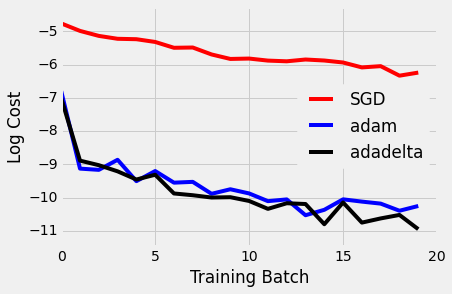

In [10]:
batchSize = 200
nIters = 20
inp_seq_len = [5,5]


# Reset parameters, train with SGD
iw.set_value(dflt_iwN)
hw.set_value(dflt_hwN)
ow.set_value(dflt_owN)
bCostSGD = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(np.random.randint(inp_seq_len[0],inp_seq_len[1]+1),dflt_iwT,dflt_hwT,dflt_owT)
        #
        currCost[i] = f_train_SGD(x,y)
    bCostSGD[b] = np.log(np.mean(currCost))

# Reset parameters, train with adam
iw.set_value(dflt_iwN)
hw.set_value(dflt_hwN)
ow.set_value(dflt_owN)
bCostAdam = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(np.random.randint(inp_seq_len[0],inp_seq_len[1]+1),dflt_iwT,dflt_hwT,dflt_owT)
        #
        currCost[i] = f_train_adam(x,y)
    bCostAdam[b] = np.log(np.mean(currCost))
    
# Reset parameters, train with adadelta
iw.set_value(dflt_iwN)
hw.set_value(dflt_hwN)
ow.set_value(dflt_owN)
bCostAdadelta = np.zeros(nIters)
for b in range(nIters):
    currCost = np.zeros(batchSize)
    for i in range(len(currCost)):
        x,y = fake_data(np.random.randint(inp_seq_len[0],inp_seq_len[1]+1),dflt_iwT,dflt_hwT,dflt_owT)
        #
        currCost[i] = f_train_adadelta(x,y)
    bCostAdadelta[b] = np.log(np.mean(currCost))

# Plot the progress of SGD and Adam (same "true" network, same starting params)
fig = plt.figure
ax = plt.axes();
ax.plot(np.arange(nIters),bCostSGD,'r-',np.arange(nIters),bCostAdam,'b',np.arange(nIters),bCostAdadelta,'k');
bCost = np.concatenate((bCostSGD,bCostAdam,bCostAdadelta))
ax.set_ylim([np.min(bCost)-.5,np.max(bCost)+.5]);
ax.set_ylabel('Log Cost');
ax.set_xlabel('Training Batch');
ax.legend(['SGD','adam','adadelta'],loc='best');

In [368]:
# This is for seeing how things work when you index into some variable along the way (and that index changes)

I = T.iscalar('I')
V = theano.shared(np.zeros(5).astype(theano.config.floatX),name='V')

def grab_idx(V,I):
    return V[I]
V_i = grab_idx(V,I)
err = (V_i-(I+1))**2
cost = err.sum()

# A more general function that returns a pair of functions that, called sequentially, train using Adam!
f_adam_helpers, f_adam_train = adam_loves_theano([I],cost,[V],alpha=.01)
# This function implements that sequential calling into one trianing step:
def f_train_adam(I):
    f_adam_helpers(I)
    return f_train(I)

In [479]:
print f_train_Adam(np.random.randint(0,5))
print V.get_value()

12.6008719889
[ 0.45882202  0.43293329  0.49719654  0.45672304  0.44811538]
